### In this section we impletment a bit flip error correction for for a two qubit system

Based on the mechanisms pot forth in [DOI: 10.1038/ncomms7979](https://www.nature.com/articles/ncomms7979), we implement a circuit that checks the pairity of the two qubits.

If the correct pairity is known *a priori*, we also implement a way to correct the pairity by flipping a bit.

If we are working only with Bell states, this method can completely correct the bit-flip error at the risk of changing the phase. This, however, cannot be observed using just the Z-basis measuremets we use.

We also test this method, for an arbitrary superposition of two-qubits. While this is not guarenteed to correct the state completely, we test how this disagreement changes with different error rates

In [79]:
import numpy as np
import os
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer
from IPython.display import display, Math, Latex
from quantuminspire.credentials import get_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit import QI
from qiskit import Aer

In [80]:
#backend = Aer.get_backend('aer_simulator')
## Use this if you do not have access to quantuminspire
QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL)
backend = QI.get_backend('QX single-node simulator')




# Bell States 
### Affected by bit flip errors

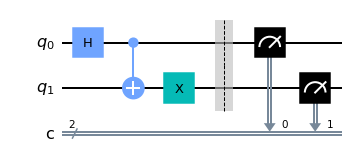

In [111]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cnot(0,1)
qc.x(1)
qc.barrier()
qc.measure([0,1],[0,1])
qc.draw(output='mpl')

#### To indudude noise "selectively" in the channels, we use Rx($\theta$) gates to put another qubit in a superpositon, measure it to collapse in |0) or |1) with a probability contolled by $\theta$. We use this measured value to conditionally flip the state in the channel.  

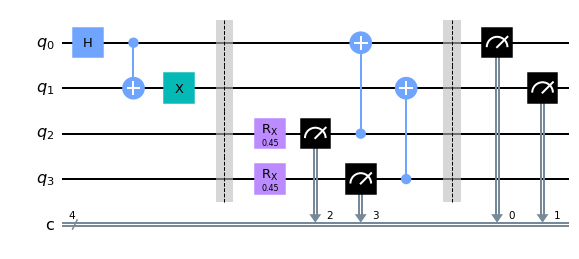

In [112]:
qc = QuantumCircuit(4,4)
qc.h(0)
qc.cnot(0,1)
qc.x(1)
qc.barrier()
qc.rx(0.45, 2)
qc.rx(0.45, 3)
qc.measure(2,2)
qc.measure(3,3)

qc.cx(2,0)
qc.cx(3,1)
qc.barrier()
qc.measure([0,1],[0,1])
qc.draw(output='mpl')

In [113]:
noise_dict = {'00':0,'01':0,'10':0,'11':0}
j=execute(qc, backend=backend, shots=1024)###, noise_model = noise_model)
result = j.result()
for meas in result.get_counts().items():
    noise_dict[meas[0][-2:]] += int(meas[1])

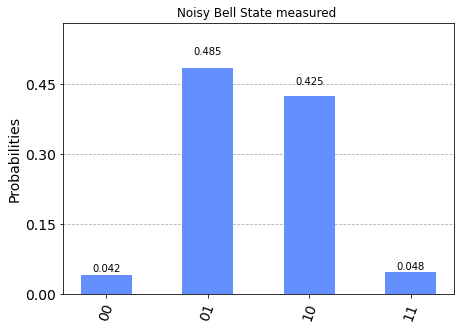

In [114]:
plot_histogram(noise_dict, title="Noisy Bell State measured ")

# Bell State
### Noise mitigated

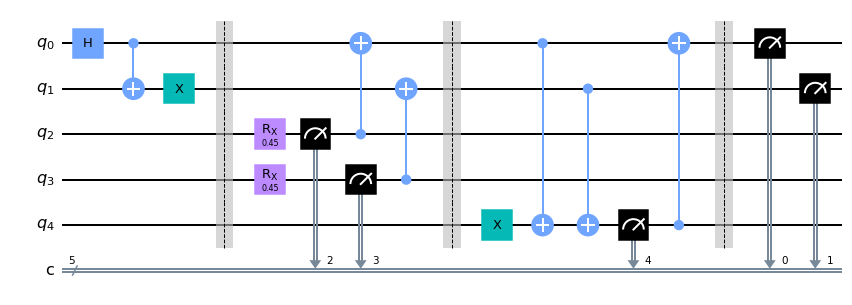

In [115]:
qc = QuantumCircuit(5,5)
qc.h(0)
qc.cnot(0,1)
qc.x(1)
qc.barrier()
qc.rx(0.45, 2)
qc.rx(0.45, 3)
qc.measure(2,2)
qc.measure(3,3)

qc.cx(2,0)
qc.cx(3,1)
qc.barrier()

qc.x(4)
qc.cx(0,4)
qc.cx(1,4)
qc.measure(4,4)
qc.cx(4,0)
qc.barrier()

qc.measure([0,1],[0,1])
qc.draw(output='mpl')

In [120]:
corr_dict = {'00':0,'01':0,'10':0,'11':0}
j=execute(qc, backend=backend, shots=1024)
result = j.result()
for meas in result.get_counts().items():
    corr_dict[meas[0][-2:]] += int(meas[1])


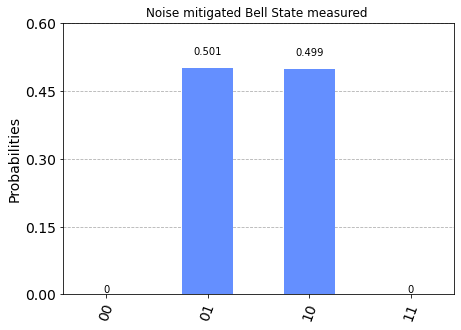

In [121]:
plot_histogram(corr_dict,  title="Noise mitigated Bell State measured ")

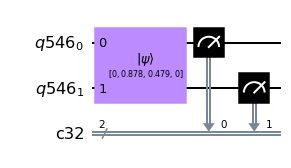

In [96]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)
theta = 0.5
desired_vector = [0,np.cos(theta),np.sin(theta),0]
qc.initialize(desired_vector, [q[0],q[1]])
qc.measure([0,1],[0,1])
qc.draw(output='mpl')





{'01': 25280, '10': 7488}


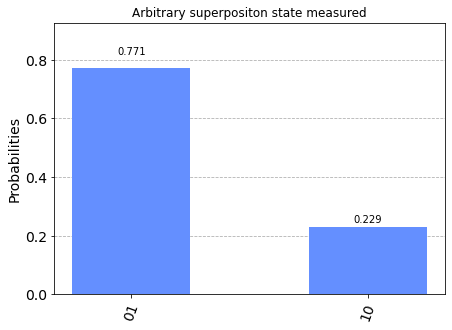

In [97]:
j=execute(qc, backend=backend, shots=1024*32)###, noise_model = noise_model)
result = j.result()

print(result.get_counts())
plot_histogram(result.get_counts(), title="Arbitrary superpositon state measured")

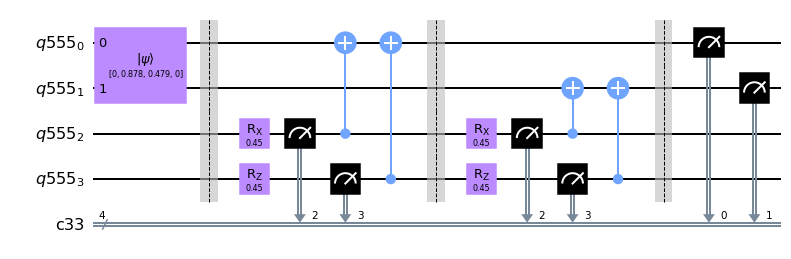

In [98]:
q = QuantumRegister(4)
c = ClassicalRegister(4)
qc = QuantumCircuit(q,c)
theta = 0.5
desired_vector = [0,np.cos(theta),np.sin(theta),0]
qc.initialize(desired_vector, [q[0],q[1]])

qc.barrier()
qc.rx(0.45, 2)
qc.rz(0.45, 3)
qc.measure(2,2)
qc.measure(3,3)
qc.cx(2,0)
qc.cx(3,0)
qc.barrier()


qc.rx(0.45, 2)
qc.rz(0.45, 3)
qc.measure(2,2)
qc.measure(3,3)

qc.cx(2,1)
qc.cx(3,1)
qc.barrier()
qc.measure([0,1],[0,1])
qc.draw(output='mpl')

In [99]:
noise_dict = {'00':0,'01':0,'10':0,'11':0}
j=execute(qc, backend=backend, shots=1024*32)###, noise_model = noise_model)
result = j.result()
for meas in result.get_counts().items():
    noise_dict[meas[0][-2:]] += int(meas[1])
    

got {'0011': 17, '0111': 1180, '0100': 324, '0001': 22754, '0110': 1217, '0101': 346, '0000': 54, '0010': 6876}
{'00': 378, '01': 23100, '10': 8093, '11': 1197}


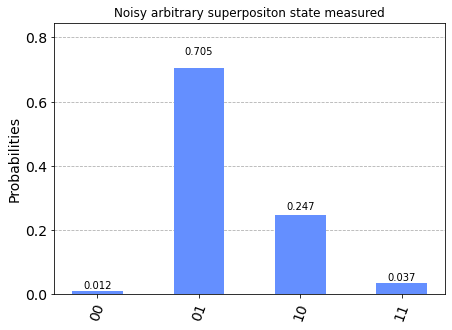

In [100]:
plot_histogram(noise_dict , title="Noisy arbitrary superpositon state measured")

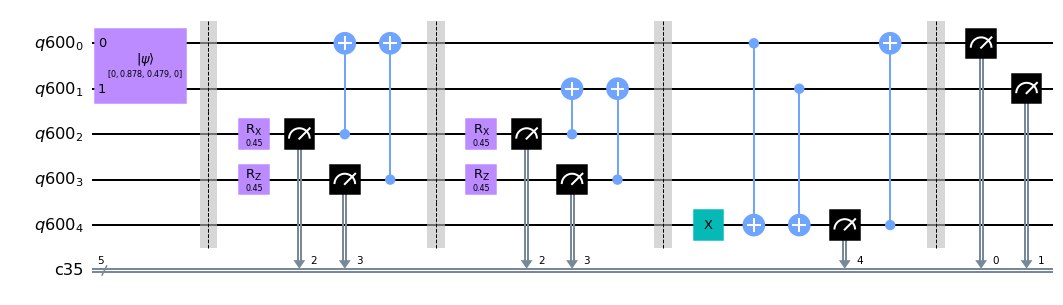

In [104]:
q = QuantumRegister(5)
c = ClassicalRegister(5)
qc = QuantumCircuit(q,c)
theta = 0.5
desired_vector = [0,np.cos(theta),np.sin(theta),0]
qc.initialize(desired_vector, [q[0],q[1]])

# qc.h(0)
# qc.cnot(0,1)
# qc.x(1)
qc.barrier()
qc.rx(0.45, 2)
qc.rz(0.45, 3)
qc.measure(2,2)
qc.measure(3,3)
qc.cx(2,0)
qc.cx(3,0)
qc.barrier()

qc.rx(0.45, 2)
qc.rz(0.45, 3)
qc.measure(2,2)
qc.measure(3,3)
qc.cx(2,1)
qc.cx(3,1)
qc.barrier()


qc.x(4)
qc.cx(0,4)
qc.cx(1,4)
qc.measure(4,4)
qc.cx(4,0)
qc.barrier()

qc.measure([0,1],[0,1])
qc.draw(output='mpl')

In [105]:
corr_dict = {'00':0,'01':0,'10':0,'11':0}
j=execute(qc, backend=backend, shots=1024*32)###, noise_model = noise_model)
result = j.result()
for meas in result.get_counts().items():
    corr_dict[meas[0][-2:]] += int(meas[1])


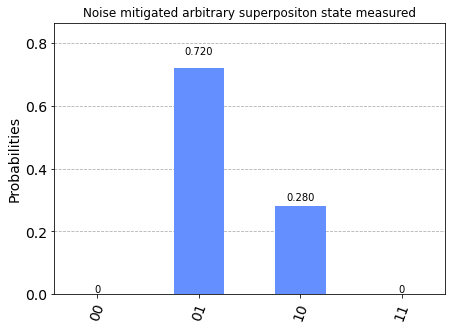

In [106]:
plot_histogram(corr_dict , title="Noise mitigated arbitrary superpositon state measured")